In [1]:
# Import libraries
import pandas as pd
from pandas_datareader import data as pdr

import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

import talib, re, ipyparams

from Agent import Agent

C:\Users\Elid-PC.DESKTOP-MG9DS93\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


<IPython.core.display.Javascript object>

Using TensorFlow backend.


In [2]:
end_date = '2020-02-19'
start_date = '2017-02-20'

symbol = 'HD'
Date = pd.DataFrame(pdr.DataReader(symbol,'yahoo', start_date, end_date))

alldata = pd.DataFrame({'Date': Date.index})
alldata[symbol] = pdr.DataReader(symbol, 'yahoo', start_date, end_date)['Adj Close'].values
# Stock symbol

# Load close prices of to NumPy array
close = alldata[symbol].values
len(close)

754

In [3]:
close

array([134.04904175, 134.2616272 , 133.76249695, 134.90867615,
       134.30789185, 133.94740295, 135.58343506, 136.75737   ,
       136.62796021, 135.99943542, 135.79481506, 136.63182068,
       136.3527832 , 136.56669617, 137.1060791 , 136.85499573,
       137.58966064, 138.31506348, 139.12413025, 137.45018005,
       136.34350586, 137.04100037, 137.62687683, 137.3664856 ,
       136.58529663, 136.89219666, 136.74339294, 136.65969849,
       136.5480957 , 136.3527832 , 136.09240723, 136.37142944,
       136.92941284, 136.82711792, 137.83146667, 137.82214355,
       136.27839661, 135.69255066, 136.99449158, 137.41299438,
       136.91079712, 138.30577087, 139.49609375, 141.25378418,
       142.31393433, 143.42062378, 145.18757629, 145.16896057,
       143.41131592, 144.09950256, 144.14601135, 144.01580811,
       144.82485962, 145.90365601, 146.63829041, 147.05680847,
       145.26196289, 145.93153381, 146.31283569, 147.17770386,
       145.15966797, 144.79698181, 145.35498047, 145.03

In [4]:
macd, macdsignal, macdhist = talib.MACD(close, fastperiod=5, slowperiod=20, signalperiod=9)
macdhist = macdhist[~np.isnan(macdhist)]
macd = macd[-len(macdhist):]
macdsignal = macdsignal[-len(macdhist):]


pd.DataFrame({'macd': macd, 'macdsignal': macdsignal, 'macdhist': macdhist}).head()

,macd,macdsignal,macdhist
0,0.312271,0.881871,-0.569600
1,0.211488,0.747794,-0.536306
2,0.097481,0.617732,-0.520250
3,-0.036373,0.486911,-0.523284
4,-0.049522,0.379624,-0.429147


In [5]:
def prepare_dataset(close):
    """
    Function prepare_dataset to generate input data and trading strategy from stock close prices
    """

    macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)

    # Cancel NaN values
    macdhist = macdhist[~np.isnan(macdhist)]
    macd = macd[-len(macdhist):]
    macdsignal = macdsignal[-len(macdhist):]

    # Scaling features to a range [0, 1]
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    macdhist_norm = min_max_scaler.fit_transform(np.expand_dims(macdhist, axis=1))

    # Implement strategy
    start_sell = 0.2
    stop_sell = 0.05
    start_buy = -0.2
    stop_buy = -0.05

    y = np.full(len(macdhist), np.nan)
    y[0] = 0

    for i in range(1, len(macdhist)):

        if y[i-1] == 0:
            if (macdhist_norm[i] >= start_sell):
                # Enter sell position
                y[i] = -1
            elif (macdhist_norm[i] <= start_buy):
                # Enter buy position
                y[i] = 1
            else:
                y[i] = 0
        elif y[i-1] == -1:
            if macdhist_norm[i] > stop_sell:
                # Stay in sell position
                y[i] = -1
            else:
                # Leave sell position
                y[i] = 0
        else:
            if macdhist_norm[i] < stop_buy:
                # Stay in buy position
                y[i] = 1
            else:
                # Leave buy position
                y[i] = 0

    # Plot strategy
    dates = np.arange(len(macdhist))
    plt.plot(dates, y,'g', label='Strategy Positions')
    plt.bar(dates, macdhist_norm[:, 0], width=1, color='blue', label='MACD histogram')
    plt.plot(dates, start_sell * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, stop_sell * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, start_buy * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, stop_buy * np.ones(len(macdhist)), 'k--', lw=1)
    plt.xlabel('Days')
    plt.xlim((0, len(y)))
    plt.legend()
    # plt.savefig('images/AAL_macd.png', bbox_inches='tight')
    plt.show()
    
    # Generate input data - technical indicators
    ind1 = talib.MIDPOINT(close)    # Overlap: MidPoint over period
    ind2 = talib.HT_DCPERIOD(close) # Cycle Indicator Functions:  Hilbert Transform - Dominant Cycle Period
    ind3 = talib.MAX(close)         # Math Operator: Highest value over a specified period
    ind4 = talib.SIN(close)         # Math Transform: Vector Trigonometric Sin
    ind5 = talib.APO(close)         # Momentum: Absolute Price Oscillator
    ind6 = talib.TEMA(close, timeperiod=5) ## Triple Exponential Moving Average

    x = np.vstack((macdhist, macd, macdsignal, ind1[-len(macdhist):], ind2[-len(macdhist):],
                   ind3[-len(macdhist):], ind4[-len(macdhist):], ind5[-len(macdhist):],
                   ind6[-len(macdhist):]))
    x = x.T

    return x, y

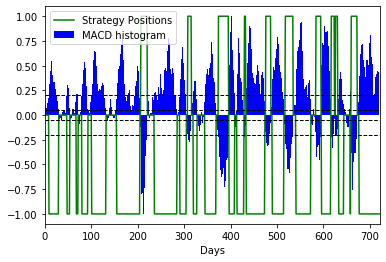

In [6]:
# Implement MACD trading strategy
X, y = prepare_dataset(close)

In [7]:
X[0]

array([-2.72111924e-01,  3.64919363e-01,  6.37031286e-01,  1.36859642e+02,
        1.72117648e+01,  1.39124130e+02, -9.85948321e-01, -1.27066686e-01,
        1.36832278e+02])

In [8]:
# Split dataset
n_train = int(X.shape[0] * 0.8)

X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

In [9]:
# Normalize data
scaler = preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Encode trading signal with integers between 0 and n-1 classes
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(le.classes_)

[-1.  0.  1.]


In [11]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [12]:
## Create and train the Agent
# Variable definiton
episodes = 20
look_back = 5
batch_size = 32
action_size = len(le.classes_)
n_features = X_train.shape[1]

In [13]:
# Create Agent
agent = Agent(look_back, action_size, n_features)

In [14]:
def run(agent, dataX, dataY, episodes, look_back):
    """
    Function run to train the agent
    """
    
    # Length of dataset
    times = len(dataX)

    # List of total rewards
    total_reward_list = []

    for ep in range(episodes):

        # print('Episode: ' + str(ep))
        
        # Initial state and position
        state = dataX[:look_back, :][np.newaxis, :, :]
        pos = dataY[look_back - 1]

        done = False
        total_reward = 0

        for t in range(1, times - look_back + 1):

            # Predict action based on the current state
            action = agent.act(state)

            # Calculate reward
            if action == pos:   # 0:-1      1:0     2:1
                reward = +1

            elif (pos == 0 or pos == 2):
                if action == 1:
                    reward = 0
                else:
                    reward = -1
            else:
                reward = -1

            total_reward += reward

            # Final state
            if t == times - look_back:
                done = True

            # Receive next state and position
            next_state = dataX[t:t + look_back, :][np.newaxis, :, :]
            next_pos = dataY[t + look_back - 1]
            
            # Remember current experience
            agent.remember(state, action, reward, next_state, done)
            
            # Make next_state the new current state; the same for pos
            state = next_state
            pos = next_pos

            if done:
                print('Episode: %i ---> Total Reward: %i' %(ep, total_reward))
                total_reward_list.append(total_reward)

            # Train the agent with previous experiences
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        if (ep + 1) % 5 == 0 and ep > 0:
            file = 'checkpoints/' + symbol + '_robot_checkpoint' + str(ep + 1)
            # Serialize weights to HDF5
            agent.model.save_weights(file + ".h5")
            # Save epsilon
            pickle.dump(agent.epsilon, open(file + "_epsilon.pickle", "wb"))

    # Save list of rewards along the epochs
    np.savetxt(file + '_total_reward.txt', total_reward_list)

    return


In [15]:
# Train Agent
run(agent, X_train, y_train, episodes, look_back)

Episode: 0 ---> Total Reward: 39
Episode: 1 ---> Total Reward: 324
Episode: 2 ---> Total Reward: 389
Episode: 3 ---> Total Reward: 419
Episode: 4 ---> Total Reward: 419
Episode: 5 ---> Total Reward: 423
Episode: 6 ---> Total Reward: 407
Episode: 7 ---> Total Reward: 428
Episode: 8 ---> Total Reward: 424
Episode: 9 ---> Total Reward: 426
Episode: 10 ---> Total Reward: 458
Episode: 11 ---> Total Reward: 440
Episode: 12 ---> Total Reward: 429
Episode: 13 ---> Total Reward: 439
Episode: 14 ---> Total Reward: 436
Episode: 15 ---> Total Reward: 427
Episode: 16 ---> Total Reward: 438
Episode: 17 ---> Total Reward: 430
Episode: 18 ---> Total Reward: 437
Episode: 19 ---> Total Reward: 453


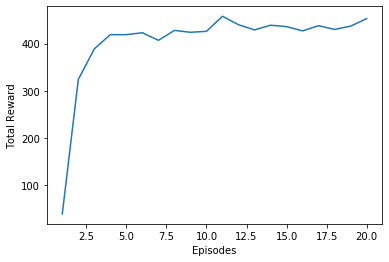

In [16]:
# Load rewards
total_reward_list = np.loadtxt( 'checkpoints/'+ symbol + '_robot_checkpoint' + str(episodes) + '_total_reward.txt')
# Plot
plt.figure()
plt.plot(np.arange(1, episodes+1), total_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

In [17]:
total_reward_list

array([ 39., 324., 389., 419., 419., 423., 407., 428., 424., 426., 458.,
       440., 429., 439., 436., 427., 438., 430., 437., 453.])

In [18]:
def evaluate(agent, dataX, dataY, look_back):
    """
    Function run to evaluate the trained agent
    """
    
    # Length of dataset
    times = len(dataX)

    # Initial state and position
    state = dataX[:look_back, :][np.newaxis, :, :]
    pos = dataY[look_back - 1]

    # List of predicted positions
    pos_list = []
    
    done = False
    total_reward = 0
    
    for t in range(1, times - look_back + 1):

        # Predict action based on the current state
        action = agent.act(state)

        # Calculate reward
        if action == pos:   # 0:-1      1:0     2:1
            reward = +1

        elif (pos == 0 or pos == 2):
            if action == 1:
                reward = 0
            else:
                reward = -1
        else:
            reward = -1

        pos_list.append(action)
        total_reward += reward

        # Final state
        if t == times - look_back:
            done = True

        # Receive next state and position
        next_state = dataX[t:t + look_back, :][np.newaxis, :, :]
        next_pos = dataY[t + look_back - 1]

        # Remember current experience
        agent.remember(state, action, reward, next_state, done)

        # Make next_state the new current state; the same for pos
        state = next_state
        pos = next_pos

        if done:
            print('Total Reward: %i' % total_reward)

    return np.array(pos_list)

In [19]:
# Evaluate the model
# Make predictions
y_pred_test = evaluate(agent, X_test, y_test, look_back)

# Calculate and print accuracy
acc = accuracy_score(y_test[look_back-1:-1], y_pred_test)

print('Accuracy: %.2f %%' % (acc*100))

Total Reward: 66
Accuracy: 49.29 %


In [20]:
# Calculate and print precision, recall, f1 score and support
p, r, f1, s = precision_recall_fscore_support(y_test[look_back-1:-1], y_pred_test, average=None)
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)

print(results.round(decimals=3))

      1-Precision  2-Recall  3-F1 score  4-Support
-1.0        0.935     0.573       0.711         75
 0.0        0.277     0.897       0.423         29
 1.0        0.000     0.000       0.000         36


C:\Users\Elid-PC.DESKTOP-MG9DS93\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Decodificate labels
y_true_test = le.inverse_transform(y_test[look_back-1:-1])
y_pred_test = le.inverse_transform(y_pred_test)

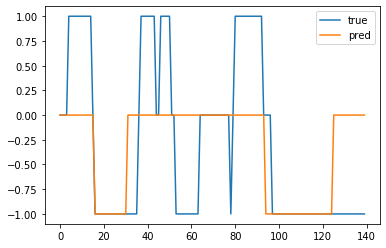

In [22]:
# Plot strategy
plt.figure()
plt.plot(y_true_test, label='true')
plt.plot(y_pred_test, label='pred')
plt.legend()
plt.show()